In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from scipy.special import zeta
from scipy.stats import norm
from scipy.optimize import minimize, minimize_scalar
from scipy.special import logsumexp
import matplotlib.gridspec as gridspec
import warnings
import os
from matplotlib.lines import Line2D

# Analyzing Lake Data
### Importing data and setting the main parameters. This dataset is referred to as cascade in most of the code

In [2]:
FILE_PATH = "raw_data_638.csv"
MIN_OBSERVATIONS = 30 
MIN_TAIL_SIZE = 10 #accepted tail data size
PROXIES = {'ABUNDANCE': 'Count', 'BIOMAS': 'Mass'}
N_SIMS = 1000 #amount of simulations for tail distribution testing

### Define initial functions

In [3]:
def find_optimal_xmin(data):
    "Find the optimal x_min that tail starts for biomass data by minimizing KS distance."
    sorted_data = np.sort(data)
    # test unique values as candidates for x_min
    unique_values = np.unique(sorted_data)
    
    # Need at least MIN_TAIL_SIZE points for valid tail estimation in the analysis
    if len(sorted_data) < MIN_TAIL_SIZE:
        return None, None, None, None

    # Don't search the very end of the tail
    search_space = unique_values[unique_values < sorted_data[-20]]
    
    best_xmin = None
    best_alpha = None
    min_KS = float('inf')
    best_ntail = 0
    
    for x_min in search_space:
        tail_data = data[data >= x_min]
        n_tail = len(tail_data)
        
        # Continuous MLE Estimate (Hill Estimator)
        # alpha = 1 + n / sum(ln(x / xmin))
        sum_log = np.sum(np.log(tail_data / x_min))
        if sum_log == 0: continue
        alpha = 1 + (n_tail / sum_log)
        
        # KS Statistic Calculation for continuous data like biomass as ours
        # Theoretical CDF is P(X <= x) = 1 - (x / xmin)^(-alpha + 1)
        # We compare P(X >= x) which is (x / xmin)^(-alpha + 1)
        
        tail_sorted = np.sort(tail_data)
        y_empirical = np.arange(n_tail) / n_tail # empirical cumulative distribution function
        
        # Theoretical CDF of power law pdf for the tail data
        y_theoretical = 1 - (tail_sorted / x_min) ** (-alpha + 1)
        
        D = np.max(np.abs(y_empirical - y_theoretical))
        
        if D < min_KS:
            min_KS = D
            best_xmin = x_min
            best_alpha = alpha
            best_ntail = n_tail
            
    return best_xmin, best_alpha, min_KS, best_ntail

def generate_synthetic_data(n, x_min, alpha, original_data):
    "Generate synthetic continuous dataset"
    n_tail = np.sum(original_data >= x_min)
    prob_tail = n_tail / len(original_data)
    
    # Decide tail versus head counts
    r = np.random.uniform(0, 1, n)
    num_tail_syn = np.sum(r < prob_tail)
    num_head_syn = n - num_tail_syn
    
    # Generate the tail with continuous inverse transform in the form x = xmin * (1 - u)^(-1 / (alpha - 1))
    u = np.random.uniform(0, 1, num_tail_syn)
    synthetic_tail = x_min * (1 - u) ** (-1 / (alpha - 1))
    
    # generate head by resampling from original < x_min
    original_head = original_data[original_data < x_min]
    if len(original_head) > 0:
        synthetic_head = np.random.choice(original_head, num_head_syn, replace=True)
    else:
        synthetic_head = np.array([])
        
    return np.concatenate([synthetic_head, synthetic_tail])

def calculate_p_value(data, x_min_fit, alpha_fit, ks_stat_fit, n_sims):
    "Calculate p value using Monte Carlo simulations"
    count_worse_fit = 0
    
    for i in range(n_sims):
        if n_sims >= 10 and (i+1) % (n_sims // 10) == 0:
            print(f"      Sim {i+1}/{n_sims}", end='\r')
            
        syn_data = generate_synthetic_data(len(data), x_min_fit, alpha_fit, data)
        
        # Fit synthetic data
        _, _, ks_syn, _ = find_optimal_xmin(syn_data)
        
        if ks_syn is not None and ks_syn >= ks_stat_fit:
            count_worse_fit += 1
            
    return count_worse_fit / n_sims

### Define the main class of functions and main analysis function

In [4]:
class ContinuousModelTester:
    "Handle fitting and comparing alternative distributions such as Exponential and Lognormal against the Power Law "
    def __init__(self, data, x_min):
        # We only look at the tail data for model comparison
        self.data = data[data >= x_min]
        self.x_min = x_min
        self.n = len(self.data)
        self.log_x = np.log(self.data) # precompute log x
        
        # placeholders for parameters
        self.lambda_exp = None
        self.mu_ln = None
        self.sigma_ln = None
        
    def fit_exponential(self):
        "Fit truncated exponential exp(-lambda * x) MLE"
        self.lambda_exp = 1.0 / (np.mean(self.data) - self.x_min)
        return self.lambda_exp

    def log_likelihood_exponential(self):
        "Loglikelihood for exponential LL = n * ln(lambda) - lambda * sum(x - x_min)"
        if self.lambda_exp is None: self.fit_exponential()
        return self.n * np.log(self.lambda_exp) - self.lambda_exp * np.sum(self.data - self.x_min)

    def fit_lognormal(self):
        "Fit truncated lognormal vith numerical optimization"
        # Initial guesses based on standard lognormal MLE of the tail data
        mu_init = np.mean(self.log_x)
        sigma_init = np.std(self.log_x, ddof=1)
        
        def neg_log_likelihood(params):
            mu, sigma = params
            if sigma <= 1e-10: return 1e10 # Prevent sigma <= 0
            
            # PDF term (summed over all data points)
            # log(pdf) = -ln(x) - ln(sigma) - 0.5*ln(2pi) - (ln(x)-mu)^2 / (2*sigma^2)
            # We precomputed self.log_x
            pdf_term = -self.log_x - np.log(sigma) - 0.5 * np.log(2 * np.pi) - ((self.log_x - mu)**2 / (2 * sigma**2))
            
            # Truncation term (Normalization constant)
            # We need the area of the PDF from x_min to infinity.
            # Z score for x_min
            z_min = (np.log(self.x_min) - mu) / sigma
            
            # Robust log survival calculation to fix dividing by zero in log
            # norm.sf(z) is 1 - cdf(z).
            # norm.logsf(z) computes log(1 - cdf(z)) directly and safely.
            log_survival = norm.logsf(z_min)
            
            # Total log likelihood is Sum(PDF terms) - n * log(Normalization)
            ll = np.sum(pdf_term) - self.n * log_survival
            return -ll # Minimize negative likelihood

        # Run the optimization
        try:
            result = minimize(neg_log_likelihood, [mu_init, sigma_init], method='Nelder-Mead')
            self.mu_ln, self.sigma_ln = result.x
        except Exception as e:
            # Fallback if optimization fails
            print(f"    Warning: Lognormal fit failed: {e}")
            self.mu_ln, self.sigma_ln = mu_init, sigma_init
            
        return self.mu_ln, self.sigma_ln

    def log_likelihood_lognormal(self):
        "Calculate Log likelihood for fitted Lognormal"
        if self.mu_ln is None: self.fit_lognormal()
        
        mu, sigma = self.mu_ln, self.sigma_ln
        
        pdf_term = -self.log_x - np.log(sigma) - 0.5 * np.log(2 * np.pi) - ((self.log_x - mu)**2 / (2 * sigma**2))
        z_min = (np.log(self.x_min) - mu) / sigma
        log_survival = norm.logsf(z_min) # Robust calculation
        
        return np.sum(pdf_term) - self.n * log_survival

    def log_likelihood_powerlaw(self, alpha):
        "Log likelihood for Power Law is n * ln(alpha - 1) + n * (alpha - 1) * ln(x_min) - alpha * sum(ln(x))"
        term1 = self.n * np.log(alpha - 1)
        term2 = self.n * (alpha - 1) * np.log(self.x_min)
        term3 = -alpha * np.sum(self.log_x)
        return term1 + term2 + term3

    def likelihood_ratio_test(self, alpha_pl, model_type='exponential'):
        "Perform Likelihood Ratio Test Returns (R, p_value) R > 0: Power Law preferred R < 0: Alternative preferred"
        # Calculate vector of log likelihoods for each point (needed for Vuong's test variance)
        
        # Power Law point-wise LL is calculated as
        # p(x) = (alpha-1)/xmin * (x/xmin)^-alpha
        # ln(p) = ln(alpha-1) - ln(xmin) - alpha*ln(x/xmin)
        ll_pl_pts = np.log(alpha_pl - 1) - np.log(self.x_min) - alpha_pl * (self.log_x - np.log(self.x_min))
        
        if model_type == 'exponential':
            if self.lambda_exp is None: self.fit_exponential()
            # p(x) = lambda * exp(-lambda*(x-xmin))
            # ln(p) = ln(lambda) - lambda*(x-xmin)
            ll_alt_pts = np.log(self.lambda_exp) - self.lambda_exp * (self.data - self.x_min)
            
        elif model_type == 'lognormal':
            if self.mu_ln is None: self.fit_lognormal()
            mu, sigma = self.mu_ln, self.sigma_ln
            # PDF term for each point
            pdf_pts = -self.log_x - np.log(sigma) - 0.5*np.log(2*np.pi) - ((self.log_x - mu)**2 / (2*sigma**2))
            # Normalization (scalar, same for all points)
            z_min = (np.log(self.x_min) - mu) / sigma
            log_surv = norm.logsf(z_min)
            
            ll_alt_pts = pdf_pts - log_surv
        else:
            return 0, 1.0

        # Calculate Ratio R as
        # R = Sum(LL_PL - LL_Alt)
        R_vector = ll_pl_pts - ll_alt_pts
        R = np.sum(R_vector)
        
        # Calculate p-value where sigma = standard deviation of the LR vector
        # n = sample size
        # Statistic = R / (sigma * sqrt(n))
        
        sigma = np.std(R_vector)
        if sigma == 0:
            return R, 1.0
            
        z_stat = R / (sigma * np.sqrt(self.n))
        
        # Two-tailed p value from normal distribution
        p_val = 2 * (1 - norm.cdf(np.abs(z_stat)))
        
        return R, p_val
    
# Main analysis function
def analyze_biomass_full_suite():
    print(f"Starting biomass analysis (bootstrap + Model Comparison)")
    print(f"Loading {FILE_PATH}")
    
    try:
        df_main = pd.read_csv(FILE_PATH)
    except FileNotFoundError:
        print("Error: File not found. Please check FILE_PATH.")
        return

    # Filter species by minimum observation count
    species_counts = df_main.groupby('valid_name')['BIOMAS'].count()
    species_list = species_counts[species_counts > MIN_OBSERVATIONS].index.tolist()
    
    print(f"Found {len(species_list)} species with > {MIN_OBSERVATIONS} observations.")
    
    results = []
    
    for i, species in enumerate(species_list):
        #print(f"\n[{i+1}/{len(species_list)}] Processing: {species}")
        
        # Get Biomass Data
        df_sp = df_main[df_main['valid_name'] == species].copy()
        ts_data = df_sp['BIOMAS'].replace(0, np.nan).dropna().values
        
        if len(ts_data) < MIN_OBSERVATIONS:
            print("  Skipping: Insufficient non-zero biomass data.")
            continue
            
        # 1. Fit Power Law
        best_xmin, alpha_mle, ks_stat, n_tail = find_optimal_xmin(ts_data)
        
        if best_xmin is None:
            print("  Skipping: Could not find valid tail.")
            continue
            
        #print(f"  > Fit: alpha={alpha_mle:.2f}, xmin={best_xmin:.4f}, tail_n={n_tail}")
        
        # Goodness of Fit (Bootstrap p value)
        # as this is slow we do it to rule out non-PL distributions first.
        p_val = calculate_p_value(ts_data, best_xmin, alpha_mle, ks_stat, n_sims=N_SIMS)
        #print(f"  > Goodness-of-Fit p-value: {p_val:.3f}")
        
        # Initialize comparison variables
        R_exp, p_exp = np.nan, np.nan
        R_ln, p_ln = np.nan, np.nan
        verdict = "Rejected (p<0.1)"

        # Stationarity Check test using ADF test
        try:
            adf_result = adfuller(ts_data)
            adf_stat = adf_result[0]
            adf_pval = adf_result[1]
            adf_crit_val_5 = adf_result[4]['5%']
        except:
            adf_pval = np.nan
        
        # Model comparison (only if power law is plausible)
        if p_val > 0.1:
            verdict = "Plausible PL"
            
            # Initialize Tester
            tester = ContinuousModelTester(ts_data, best_xmin)
            
            # Compare vs Exponential
            # Test Heavy Tail  vs thin tail
            tester.fit_exponential()
            R_exp, p_exp = tester.likelihood_ratio_test(alpha_mle, 'exponential')
            
            # Compare versus Lognormal
            # Tests specific heavy tail shapes
            tester.fit_lognormal()
            R_ln, p_ln = tester.likelihood_ratio_test(alpha_mle, 'lognormal')
            
            #print(f"  > Vs Exp: R={R_exp:.2f}, p={p_exp:.3f}")
            #print(f"  > Vs LN:  R={R_ln:.2f}, p={p_ln:.3f}")
            
            # Refine Verdict
            if R_exp > 0 and p_exp < 0.1:
                verdict = "Strong Heavy Tail"
                if R_ln < 0 and p_ln < 0.1:
                    verdict = "Lognormal Preferred"
                elif p_ln > 0.1:
                    verdict = "PL/LN Indistinguishable"
                else:
                    verdict = "Power Law Preferred"
            elif R_exp < 0 and p_exp < 0.1:
                verdict = "Exponential Preferred"
        
        # Store results as below
        results.append({
            'Species': species,
            'N_total': len(ts_data),
            'N_tail': n_tail,
            'x_min': best_xmin,
            'alpha': alpha_mle,
            'KS_stat': ks_stat,
            'p_value_gof': p_val,
            'LR_Exp_R': R_exp,
            'LR_Exp_p': p_exp,
            'LR_LN_R': R_ln,
            'LR_LN_p': p_ln,
            'Verdict': verdict,
            'ADF p-val': adf_pval
        })

    # Now we report the results
    if not results:
        print("\nNo valid results generated.")
        return

    results_df = pd.DataFrame(results)
    # Sort by strongest candidates (High p-value + Positive R vs Exp)
    #results_df = results_df.sort_values(by=['Verdict', 'p_value_gof'], ascending=[False, False])
    
    accepted_df = results_df[
        (results_df['p_value_gof'] > 0.0) & #either show all the results or the ones with p>0.1
        (results_df['ADF p-val'] <= 0.1)].copy()
    
    accepted_df = accepted_df.sort_values(by='alpha')
    
    print("\n" + "="*80)
    print("FINAL RESULTS")
    print("="*80)
    
    # define columns to show
    cols = ['Species', 'alpha', 'p_value_gof', 'LR_Exp_R', 'LR_LN_R', 'Verdict', 'LR_LN_p', 'LR_Exp_p' , 'ADF p-val']
    print(accepted_df[cols].to_markdown(index=False, floatfmt=".3f"))
    
    # Save to CSV
    accepted_df.to_csv("biomass_powerlaw_comparison_results.csv", index=False)
    print("\nFull results saved to 'biomass_powerlaw_comparison_results.csv'")

# Run it
if __name__ == "__main__":
    analyze_biomass_full_suite()

Starting biomass analysis (bootstrap + Model Comparison)
Loading raw_data_638.csv
Found 27 species with > 30 observations.
      Sim 1000/1000
FINAL RESULTS
| Species                  |   alpha |   p_value_gof |   LR_Exp_R |   LR_LN_R | Verdict                 |   LR_LN_p |   LR_Exp_p |   ADF p-val |
|:-------------------------|--------:|--------------:|-----------:|----------:|:------------------------|----------:|-----------:|------------:|
| Cyclops varicans         |   1.601 |         0.003 |    nan     |   nan     | Rejected (p<0.1)        |   nan     |    nan     |       0.000 |
| Gastropus stylifer       |   1.604 |         0.001 |    nan     |   nan     | Rejected (p<0.1)        |   nan     |    nan     |       0.000 |
| Gastropus hyptopus       |   1.605 |         0.004 |    nan     |   nan     | Rejected (p<0.1)        |   nan     |    nan     |       0.000 |
| Filinia                  |   1.643 |         0.412 |     63.373 |    -0.755 | PL/LN Indistinguishable |     0.403 | 

# Analyzing Mesocosm Data
### Define the main class of functions and main analysis function. This dataset is referred as beninca in most of the code corresponding to the article's author. 

In [5]:
# Now redifine the the variables and define some extra ones as well
FILE_PATH = "species_abundances_original.csv"
OUTPUT_FILE = "biomass_powerlaw_comparison_results.csv"
MIN_OBSERVATIONS = 30        
MIN_TAIL_SIZE = 10           
N_SIMS = 1000                
START_DATE = "1991-06-16"
END_DATE = "1997-10-20"

# I merged some codes so there might be a repetition but when every cell is run in order everything works without a problem
# Mesocosm dataset has a different form than the lake dataset so it requires handling differently
class ContinuousModelTester:
    def __init__(self, data, x_min):
        self.data = data[data >= x_min]
        self.x_min = x_min
        self.n = len(self.data)
        self.log_x = np.log(self.data)
        self.lambda_exp = None
        self.mu_ln = None
        self.sigma_ln = None
        
    def fit_exponential(self):
        self.lambda_exp = 1.0 / (np.mean(self.data) - self.x_min)
        return self.lambda_exp

    def fit_lognormal(self):
        mu_init = np.mean(self.log_x)
        sigma_init = np.std(self.log_x, ddof=1)
        def neg_log_likelihood(params):
            mu, sigma = params
            if sigma <= 1e-10: return 1e10
            pdf_term = -self.log_x - np.log(sigma) - 0.5 * np.log(2 * np.pi) - ((self.log_x - mu)**2 / (2 * sigma**2))
            z_min = (np.log(self.x_min) - mu) / sigma
            log_survival = norm.logsf(z_min)
            ll = np.sum(pdf_term) - self.n * log_survival
            return -ll
        try:
            result = minimize(neg_log_likelihood, [mu_init, sigma_init], method='Nelder-Mead')
            self.mu_ln, self.sigma_ln = result.x
        except:
            self.mu_ln, self.sigma_ln = mu_init, sigma_init
        return self.mu_ln, self.sigma_ln

    def likelihood_ratio_test(self, alpha_pl, model_type='exponential'):
        ll_pl_pts = np.log(alpha_pl - 1) - np.log(self.x_min) - alpha_pl * (self.log_x - np.log(self.x_min))
        if model_type == 'exponential':
            if self.lambda_exp is None: self.fit_exponential()
            ll_alt_pts = np.log(self.lambda_exp) - self.lambda_exp * (self.data - self.x_min)
        elif model_type == 'lognormal':
            if self.mu_ln is None: self.fit_lognormal()
            mu, sigma = self.mu_ln, self.sigma_ln
            pdf_pts = -self.log_x - np.log(sigma) - 0.5*np.log(2*np.pi) - ((self.log_x - mu)**2 / (2*sigma**2))
            z_min = (np.log(self.x_min) - mu) / sigma
            log_surv = norm.logsf(z_min)
            ll_alt_pts = pdf_pts - log_surv
        else:
            return 0, 1.0
        R_vector = ll_pl_pts - ll_alt_pts
        R = np.sum(R_vector)
        sigma = np.std(R_vector)
        if sigma <= 1e-10: return R, 1.0
        z_stat = R / (sigma * np.sqrt(self.n))
        p_val = 2 * (1 - norm.cdf(np.abs(z_stat)))
        return R, p_val

# Other necessary functions. Again I might have done some repetition
def find_optimal_xmin(data):
    sorted_data = np.sort(data)
    unique_values = np.unique(sorted_data)
    valid_candidates = [x for x in unique_values if len(data[data >= x]) >= MIN_TAIL_SIZE]
    if not valid_candidates: return None, None, None, None

    if len(valid_candidates) > 100:
        step = len(valid_candidates) // 50
        valid_candidates = valid_candidates[::step]

    best_xmin, best_alpha, min_KS, best_ntail = None, None, float('inf'), 0
    
    for x_min in valid_candidates:
        tail_data = data[data >= x_min]
        n_tail = len(tail_data)
        if np.any(tail_data <= 0): continue
        sum_log = np.sum(np.log(tail_data / x_min))
        if sum_log == 0: continue
        alpha = 1 + (n_tail / sum_log)
        y_empirical = np.arange(n_tail) / n_tail
        tail_sorted = np.sort(tail_data)
        y_theoretical = 1 - (tail_sorted / x_min) ** (-alpha + 1)
        D = np.max(np.abs(y_empirical - y_theoretical))
        if D < min_KS:
            min_KS, best_xmin, best_alpha, best_ntail = D, x_min, alpha, n_tail
    return best_xmin, best_alpha, min_KS, best_ntail

def calculate_p_value(data, x_min, alpha, ks_stat, n_sims=100):
    n = len(data)
    n_tail = np.sum(data >= x_min)
    prob_tail = n_tail / n
    count_worse = 0
    for i in range(n_sims):
        r = np.random.uniform(0, 1, n)
        n_tail_syn = np.sum(r < prob_tail)
        head = data[data < x_min]
        syn_head = np.random.choice(head, n - n_tail_syn) if len(head) > 0 else []
        u = np.random.uniform(0, 1, n_tail_syn)
        syn_tail = x_min * (1 - u) ** (-1 / (alpha - 1))
        syn_data = np.concatenate([syn_head, syn_tail])
        _, _, ks_syn, _ = find_optimal_xmin(syn_data)
        if ks_syn is not None and ks_syn >= ks_stat:
            count_worse += 1
    return count_worse / n_sims

# Data load
def load_beninca_data(file_path):
    print(f"Reading {file_path}")
    try:
        df = pd.read_csv(file_path, header=7, encoding='ISO-8859-1')
    except UnicodeDecodeError:
        print("ISO-8859-1 failed, trying cp1252")
        df = pd.read_csv(file_path, header=7, encoding='cp1252')
    
    df.columns = df.columns.str.strip()
    df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%y', errors='coerce')
    print(f"Filtering dates from {START_DATE} to {END_DATE}")
    df = df[(df['Date'] >= START_DATE) & (df['Date'] <= END_DATE)]
    
    species_cols = [
        'Cyclopoids', 'Calanoid copepods', 'Rotifers', 'Protozoa',
        'Nanophytoplankton', 'Picophytoplankton', 'Filamentous diatoms',
        'Ostracods', 'Harpacticoids', 'Bacteria'
    ]
    valid_cols = [c for c in species_cols if c in df.columns]

    for col in valid_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    df_long = df.melt(id_vars=['Date'], value_vars=valid_cols, 
                      var_name='valid_name', value_name='BIOMAS')
    print(f"Data Loaded: {len(df_long)} observations.")
    return df_long

# Main analysis function
def analyze_biomass_full_suite():
    print(f"Starting Lake data Biomass Analysis")
    try:
        df_main = load_beninca_data(FILE_PATH)
    except FileNotFoundError:
        print("Error: File not found.")
        return

    species_counts = df_main.groupby('valid_name')['BIOMAS'].count()
    species_list = species_counts[species_counts > MIN_OBSERVATIONS].index.tolist()
    print(f"Found {len(species_list)} species with > {MIN_OBSERVATIONS} observations.")
    
    results = []
    
    for i, species in enumerate(species_list):
        print(f"[{i+1}/{len(species_list)}] Processing: {species}")
        df_sp = df_main[df_main['valid_name'] == species].copy()
        ts_data = df_sp['BIOMAS'].replace(0, np.nan).dropna().values 
        
        if len(ts_data) < MIN_OBSERVATIONS: continue
            
        best_xmin, alpha_mle, ks_stat, n_tail = find_optimal_xmin(ts_data)
        if best_xmin is None: continue
            
        p_val = calculate_p_value(ts_data, best_xmin, alpha_mle, ks_stat, n_sims=N_SIMS)
        
        R_exp, p_exp, R_ln, p_ln = np.nan, np.nan, np.nan, np.nan
        verdict = "Rejected (p<0.1)"
        
        try:
            adf_pval = adfuller(ts_data)[1]
        except:
            adf_pval = np.nan
        
        if p_val > 0.1:
            verdict = "Plausible PL"
            tester = ContinuousModelTester(ts_data, best_xmin)
            
            tester.fit_exponential()
            R_exp, p_exp = tester.likelihood_ratio_test(alpha_mle, 'exponential')
            
            tester.fit_lognormal()
            R_ln, p_ln = tester.likelihood_ratio_test(alpha_mle, 'lognormal')
            
            if R_exp > 0 and p_exp < 0.1:
                verdict = "Strong Heavy Tail"
                if R_ln < 0 and p_ln < 0.1:
                    verdict = "Lognormal Preferred"
                elif p_ln > 0.1:
                    verdict = "PL/LN Indistinguishable"
                else:
                    verdict = "Power Law Preferred"
            elif R_exp < 0 and p_exp < 0.1:
                verdict = "Exponential Preferred"
        
        print(f"  > Verdict: {verdict} (p={p_val:.3f})")

        # --- UPDATED RESULTS DICTIONARY TO MATCH CASCADE ---
        results.append({
            'Species': species,
            'N_total': len(ts_data),       # Added
            'N_tail': n_tail,              # Added
            'x_min': best_xmin,            # Added
            'alpha': alpha_mle,
            'KS_stat': ks_stat,            # Added
            'p_value_gof': p_val,
            'LR_Exp_R': R_exp,
            'LR_Exp_p': p_exp,
            'LR_LN_R': R_ln,
            'LR_LN_p': p_ln,
            'Verdict': verdict,
            'ADF p-val': adf_pval
        })

    if results:
        results_df = pd.DataFrame(results)
        
        # Append to previously created csv. That is why running this cell more than once will cause problems
        # Check if file exists to determine if we need to write the header
        file_exists = os.path.isfile(OUTPUT_FILE)
        
        results_df.to_csv(OUTPUT_FILE, mode='a', header=not file_exists, index=False)
        print(f"\nResults appended to '{OUTPUT_FILE}'")
        
        # Print summary for this run
        print("\n" + "="*80 + "\nBENINCA SUMMARY (Species with p > 0.1)\n" + "="*80)
        accepted = results_df[results_df['p_value_gof'] >= 0.0].sort_values(by='alpha') #Either include all the species or the ones with p>0.1
        cols = ['Species', 'alpha', 'p_value_gof', 'LR_Exp_R', 'LR_LN_R', 'Verdict', 'ADF p-val']
        print(accepted[cols].to_markdown(index=False, floatfmt=".3f"))
    else:
        print("No valid results.")

if __name__ == "__main__":
    analyze_biomass_full_suite()

Starting Lake data Biomass Analysis
Reading species_abundances_original.csv
Filtering dates from 1991-06-16 to 1997-10-20
Data Loaded: 6900 observations.
Found 10 species with > 30 observations.
[1/10] Processing: Bacteria
  > Verdict: Plausible PL (p=0.615)
[2/10] Processing: Calanoid copepods
  > Verdict: Rejected (p<0.1) (p=0.001)
[3/10] Processing: Cyclopoids
  > Verdict: Rejected (p<0.1) (p=0.000)
[4/10] Processing: Filamentous diatoms
  > Verdict: PL/LN Indistinguishable (p=0.216)
[5/10] Processing: Harpacticoids
  > Verdict: Plausible PL (p=0.707)
[6/10] Processing: Nanophytoplankton
  > Verdict: Rejected (p<0.1) (p=0.000)
[7/10] Processing: Ostracods
  > Verdict: Rejected (p<0.1) (p=0.023)
[8/10] Processing: Picophytoplankton
  > Verdict: Rejected (p<0.1) (p=0.000)
[9/10] Processing: Protozoa
  > Verdict: PL/LN Indistinguishable (p=0.878)
[10/10] Processing: Rotifers
  > Verdict: Rejected (p<0.1) (p=0.002)

Results appended to 'biomass_powerlaw_comparison_results.csv'

BENINCA 

# General figure to combine both datasets

Loading and merging datasets
Generating the plot


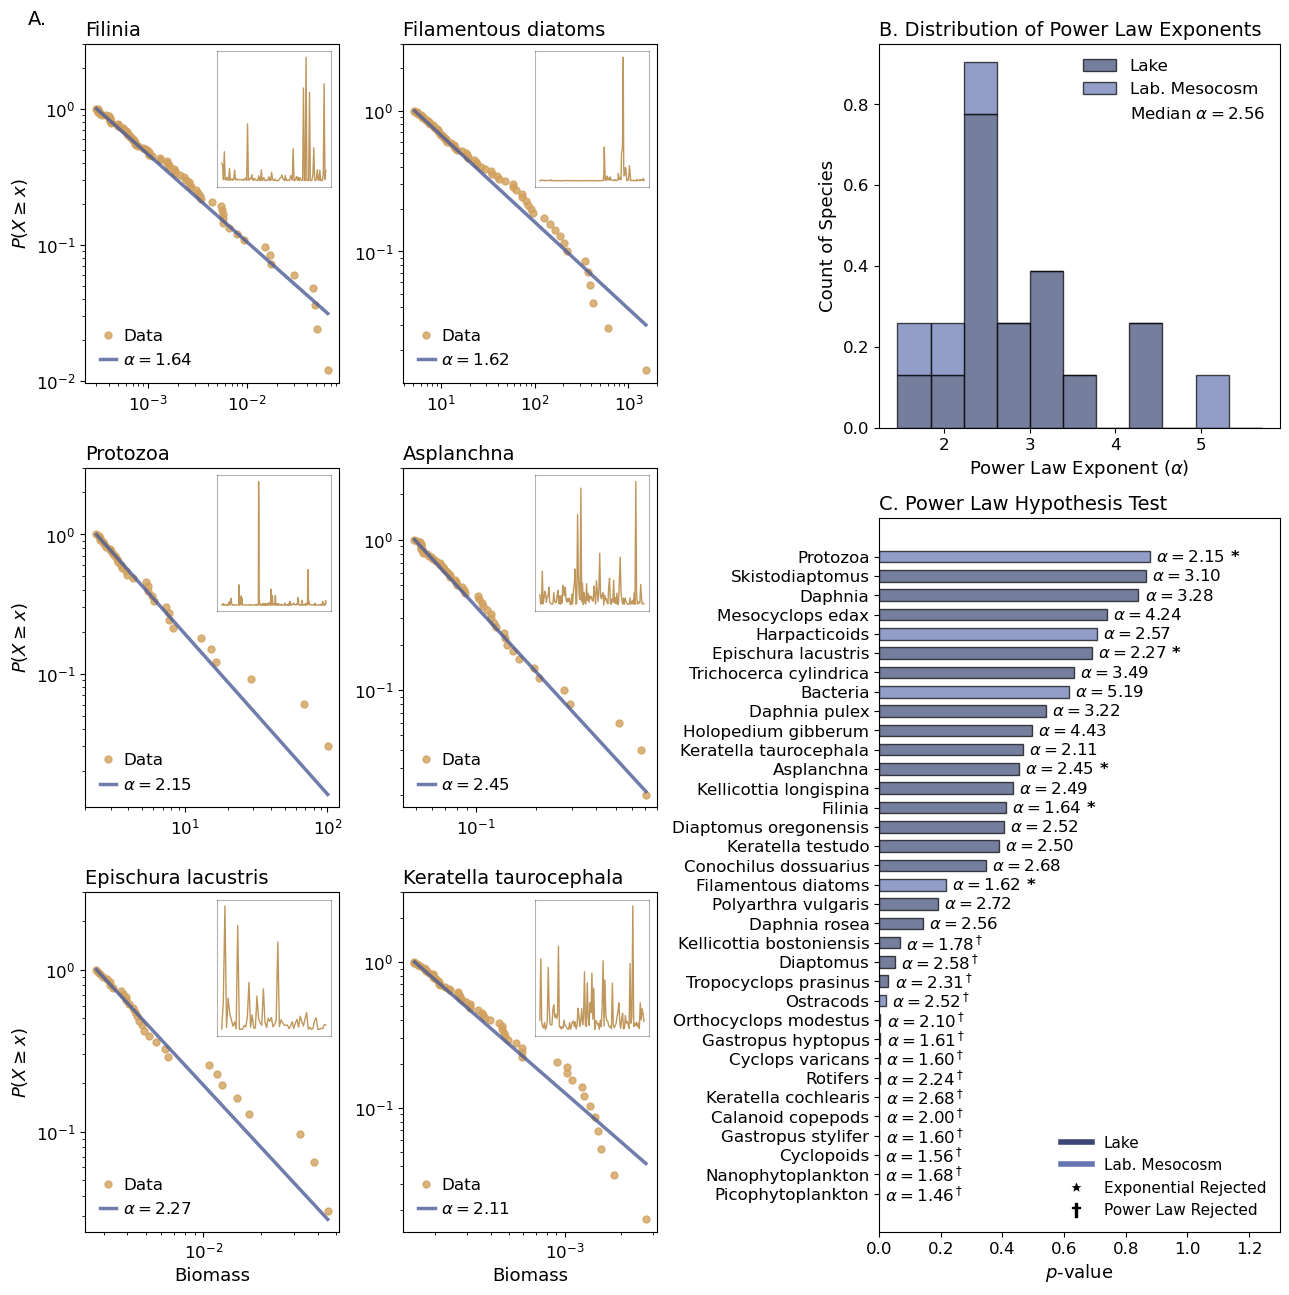

In [6]:
# Suppress warnings
warnings.filterwarnings("ignore")

# Config
RESULTS_FILE = "biomass_powerlaw_comparison_results.csv"
RAW_DATA_CASCADE = "raw_data_638.csv"
RAW_DATA_BENINCA = "species_abundances_original.csv"

# Colors for datasets
COLOR_MAP = {'Cascade': '#3b4774', 'Beninca': '#6475b1'} 

# Plotting class
class ContinuousModelTester:
    def __init__(self, data, x_min):
        self.data = data[data >= x_min]
        self.x_min = x_min
        self.n = len(self.data)
        self.log_x = np.log(self.data)
        self.lambda_exp = None
        self.mu_ln = None
        self.sigma_ln = None
        
    def fit_exponential(self):
        self.lambda_exp = 1.0 / (np.mean(self.data) - self.x_min)
        return self.lambda_exp

    def get_ccdf_curves(self, alpha):
        x_plot = np.geomspace(self.x_min, self.data.max(), 100)
        y_pl = (x_plot / self.x_min) ** (1 - alpha)
        
        if self.lambda_exp is None: self.fit_exponential()
        y_exp = np.exp(-self.lambda_exp * (x_plot - self.x_min))
        
        return x_plot, y_pl, y_exp, None

# Dataset handling
print("Loading and merging datasets")

species_source_map = {}

# Load Results
try:
    results_df = pd.read_csv(RESULTS_FILE)
except FileNotFoundError:
    print(f"Error: '{RESULTS_FILE}' not found.")
    results_df = pd.DataFrame()

# Load raw data from lake dataset
try:
    raw_cascade = pd.read_csv(RAW_DATA_CASCADE)
    if 'valid_name' in raw_cascade.columns and 'BIOMAS' in raw_cascade.columns:
        df_cascade_clean = raw_cascade[['valid_name', 'BIOMAS']].copy()
        for sp in df_cascade_clean['valid_name'].unique():
            species_source_map[sp] = 'Cascade'
    else:
        df_cascade_clean = pd.DataFrame(columns=['valid_name', 'BIOMAS'])
except FileNotFoundError:
    df_cascade_clean = pd.DataFrame(columns=['valid_name', 'BIOMAS'])

# Load raw data from mesocosm dataset
try:
    try:
        raw_ben = pd.read_csv(RAW_DATA_BENINCA, header=7, encoding='ISO-8859-1')
    except:
        raw_ben = pd.read_csv(RAW_DATA_BENINCA, header=7, encoding='cp1252')

    raw_ben.columns = raw_ben.columns.str.strip()
    raw_ben['Date'] = pd.to_datetime(raw_ben['Date'], format='%d/%m/%y', errors='coerce')
    raw_ben = raw_ben[(raw_ben['Date'] >= "1991-06-16") & (raw_ben['Date'] <= "1997-10-20")]
    
    species_cols = [c for c in raw_ben.columns if c not in ['Date', 'days', 'Unnamed']]
    df_ben_melt = raw_ben.melt(id_vars=['Date'], value_vars=species_cols, 
                               var_name='valid_name', value_name='BIOMAS')
    df_ben_melt['BIOMAS'] = pd.to_numeric(df_ben_melt['BIOMAS'], errors='coerce')
    df_ben_clean = df_ben_melt[['valid_name', 'BIOMAS']].copy()
    
    for sp in df_ben_clean['valid_name'].unique():
        species_source_map[sp] = 'Beninca'

except FileNotFoundError:
    df_ben_clean = pd.DataFrame(columns=['valid_name', 'BIOMAS'])

# Combine Raw Data
raw_df = pd.concat([df_cascade_clean, df_ben_clean], ignore_index=True)

# Map Source to results
if not results_df.empty:
    results_df['Source'] = results_df['Species'].map(species_source_map).fillna('Unknown')

# Filtre by ADF and p values
if 'ADF p-val' in results_df.columns:
    valid_pl = results_df[
        (results_df['p_value_gof'] > 0.1) & 
        (results_df['ADF p-val'].fillna(1.0) <= 0.1)
    ].copy()
else:
    valid_pl = results_df[results_df['p_value_gof'] > 0.1].copy()

if valid_pl.empty:
    print("No species met the criteria.")
else:

    # Plotting
    print("Generating the plot")

    fig = plt.figure(figsize=(13, 13)) 

    gs = gridspec.GridSpec(2, 2, width_ratios=[1, 0.7], height_ratios=[0.7, 1.3])

    # Panel A is the Top 6 Strongest Heavy Tails (Left Column)
    if 'LR_Exp_R' in valid_pl.columns:
        top_6 = valid_pl.nlargest(6, 'LR_Exp_R').copy()
    else:
        top_6 = valid_pl.head(6).copy()
    
    gs_left = gridspec.GridSpecFromSubplotSpec(3, 2, subplot_spec=gs[:, 0], 
                                               wspace=0.25, hspace=0.25)

    for idx, (i, row) in enumerate(top_6.iterrows()):
        sp = row['Species']
        data = raw_df[raw_df['valid_name'] == sp]['BIOMAS'].replace(0, np.nan).dropna().values
        
        if len(data) == 0: continue

        tester = ContinuousModelTester(data, row['x_min'])
        x_plot, y_pl, y_exp, _ = tester.get_ccdf_curves(row['alpha'])
        
        r, c = divmod(idx, 2)
        
        # CCDF plot
        ax_cc = fig.add_subplot(gs_left[r, c])
        tail_data = data[data >= row['x_min']]
        tail_sorted = np.sort(tail_data)
        y_emp = np.arange(len(tail_sorted), 0, -1) / len(tail_sorted)
        
        ax_cc.loglog(tail_sorted, y_emp, 'ko', markersize=5, alpha=0.8, label='Data', color='#d1a15d')
        ax_cc.loglog(x_plot, y_pl, 'b-', lw=2.5, label=fr'$\alpha={row["alpha"]:.2f}$', color='#4c5c96', alpha=0.8) 
        
        ax_cc.set_ylim(top=3.0) 

        # styling
        ax_cc.set_title(f"{sp}", loc='left', fontsize=14)
        ax_cc.tick_params(axis='both', labelsize=12)
        
        if c == 0:
            ax_cc.set_ylabel(r"$P(X \geq x)$", fontsize=13)
        if r == 2: 
            ax_cc.set_xlabel("Biomass", fontsize=13)
            
        ax_cc.legend(frameon=False, fontsize=12, handletextpad=0.4, handlelength=1.0, loc='lower left')

        if idx == 0:
            ax_cc.text(-0.15, 1.1, "A.", transform=ax_cc.transAxes, 
                       fontsize=14, va='top', ha='right', color='black')

        # inset plots for time series
        ax_ins = ax_cc.inset_axes([0.5176, 0.578, 0.45, 0.4])
        ax_ins.plot(data, 'k-', lw=1.0, alpha=0.8, color='#b07c32')
        
        ax_ins.set_xticks([])
        ax_ins.set_yticks([])
        # Set background to semi transparent white to ensure no stray lines interfere
        ax_ins.set_facecolor('white')
        ax_ins.patch.set_alpha(0.8)
        for spine in ax_ins.spines.values():
            spine.set_alpha(0.3) # Adjust this value (0.0 to 1.0)

    # PANEL b is Distribution of Alphas
    
    ax_b = fig.add_subplot(gs[0, 1])

    alphas_cascade = valid_pl[valid_pl['Source'] == 'Cascade']['alpha']
    alphas_beninca = valid_pl[valid_pl['Source'] == 'Beninca']['alpha']

    if len(valid_pl) > 0:
        bins = np.linspace(min(valid_pl['alpha']) * 0.9, max(valid_pl['alpha']) * 1.1, 12)
        ax_b.hist([alphas_cascade, alphas_beninca], bins=bins, stacked=True,
                  color=[COLOR_MAP['Cascade'], COLOR_MAP['Beninca']], 
                  label=['Lake', 'Lab. Mesocosm'],
                  edgecolor='black', alpha=0.7, density = True)
        
        mean_alpha = valid_pl['alpha'].mean()
        median_alpha = valid_pl['alpha'].median()

        ax_b.axvline(mean_alpha, linestyle='--', linewidth=2, label=f'Median $\\alpha = {median_alpha:.2f}$', color='#d1a15d', alpha=0.0)
        ax_b.legend(loc='upper right', frameon=False, fontsize=12)

    ax_b.set_xlabel(r"Power Law Exponent ($\alpha$)", fontsize=13)
    ax_b.set_ylabel("Count of Species", fontsize=13)
    ax_b.set_xticks([2, 3, 4, 5])
    ax_b.set_title("B. Distribution of Power Law Exponents", loc='left', fontsize=14)
    ax_b.tick_params(axis='both', labelsize=12)

    # PANEL C is for Plausibility of power law
    ax_c = fig.add_subplot(gs[1, 1])

    df_plot_c = results_df.sort_values(by='p_value_gof', ascending=True)

    if not df_plot_c.empty:
            y_pos = np.arange(len(df_plot_c))
            bar_colors = [COLOR_MAP.get(src, 'gray') for src in df_plot_c['Source']]
            
            bars = ax_c.barh(y_pos, df_plot_c['p_value_gof'], color=bar_colors, edgecolor='k', height=0.6, alpha=0.7)
            
            for i, (idx, row) in enumerate(df_plot_c.iterrows()):
                bar = bars[i]
                alpha_val = row['alpha']
                
                # Exponential Rejected (Likelihood Ratio favors PL, significant p)
                exp_rejected = (row['LR_Exp_R'] > 0) and (row['LR_Exp_p'] < 0.1)
                # Power Law Rejected (Goodness of Fit p < 0.1)
                pl_rejected = (row['p_value_gof'] < 0.1)
                
                label_text = (fr"$\alpha={alpha_val:.2f}$")
                
                # Append Markers to Text
                if exp_rejected:
                    label_text += " *"
                if pl_rejected:
                    label_text += r"$^\dagger$"
                    
                x_text = bar.get_width() + 0.02
                
                # Use bold font if either condition is met, for emphasis
                is_bold = 'bold' if (exp_rejected or pl_rejected) else 'normal'
                
                ax_c.text(x_text, bar.get_y() + bar.get_height()/2, 
                        label_text, 
                        va='center', fontsize=12, color='black', fontweight=is_bold)

            ax_c.set_yticks(y_pos)
            ax_c.set_yticklabels(df_plot_c['Species'], fontsize=12)
            ax_c.set_xlabel(r"$p$-value", fontsize=13)
            ax_c.set_title("C. Power Law Hypothesis Test", loc='left', fontsize=14)
            ax_c.tick_params(axis='both', labelsize=12)
            ax_c.set_xlim(0, 1.3)
            
            # legend
            legend_elements = [
                Line2D([0], [0], color=COLOR_MAP['Cascade'], lw=4, label='Lake'),
                Line2D([0], [0], color=COLOR_MAP['Beninca'], lw=4, label='Lab. Mesocosm'),
                Line2D([0], [0], marker='*', color='w', markerfacecolor='black', markersize=10, label='Exponential Rejected'),
                Line2D([0], [0], marker=r'$\dagger$', color='w', markerfacecolor='black', markeredgecolor='black', markersize=10, label='Power Law Rejected')
            ]
            ax_c.legend(handles=legend_elements, loc='lower right', fontsize=11, frameon=False)

    else:
        ax_c.text(0.5, 0.5, "No Plausible Models", ha='center')

    plt.tight_layout()
    plt.savefig("detailed_tail_analysis_combined.pdf")
    plt.show()